In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

from sklearn.metrics import roc_curve, roc_auc_score

models = ['logit']
fs = ["all"]
tickers = ['SPX Index']

plt.style.use('bmh')

### Lasso cross-validation

In [195]:
from sklearn.linear_model import LogisticRegression
from data_mani.utils import merge_market_and_gtrends, target_ret_to_directional_movements
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, roc_auc_score
from scipy.stats import randint as sp_randint

In [196]:
ticker_name = "SPX Index"
target_name = "target_return"

ticker_path = os.path.join(os.getcwd(), "data/indices/{}.csv".format(ticker_name))
train, test = merge_market_and_gtrends(ticker_path,
                                       test_size=0.5,
                                       is_discrete=True)
words = train.drop(labels=target_name, axis=1).columns.to_list()
complete = pd.concat([train, test])

train.tail()

/Users/danieloliveira/Documents/Daniel/codes/causal-feature/src/data_mani/utils.py:115: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  market = market.drop([0, 1], 0)  # drop first 2 lines


,target_return,BUY AND HOLD,act,arts,bank,banking,blacklist,bonds,bubble,business,...,virginia,voters,votes,war,washington,water,william,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,
2016-04-27,1,-0.501483,-0.131852,0.022728,-0.168238,-0.215818,-0.356675,0.006473,0.154151,-0.140357,...,0.986495,-0.351398,0.500720,-0.356675,-0.203228,0.131769,-0.311436,-0.810930,0.282806,-0.605040
2016-04-28,0,0.295464,-0.075986,0.073331,-0.118521,-0.194156,0.230524,-0.154151,0.161268,-0.087011,...,0.715620,0.159065,-0.475362,-0.704197,-0.171148,0.073727,0.158224,-0.496437,0.178248,-0.405465
2016-04-29,0,0.295464,-0.430783,-0.068993,-0.342979,-0.405465,0.713766,-0.334006,0.128833,-0.548566,...,0.622530,-0.534082,-0.439921,-0.596816,-0.214657,0.014515,0.087011,-0.496437,0.248461,-0.531879
2016-05-02,1,0.264693,0.012739,-0.010929,0.094598,-0.120628,-0.031749,0.000000,0.000000,0.119059,...,0.820981,0.122602,-0.108374,-0.548566,-0.188794,0.163861,0.068993,-0.416160,0.202941,-0.490206
2016-05-03,0,-0.200671,0.506561,0.210071,0.545741,0.275706,-0.609766,0.462624,0.133531,0.723919,...,0.847298,1.904237,0.746708,-0.159630,0.192372,0.039130,0.331357,-0.448950,0.133531,-0.377294


In [199]:
n_iter = 50
n_splits = 20
n_jobs = 1
verbose = False
seed = 2294

param_grid = {'C': np.linspace(0.001, 100, 100)}

lasso_model = LogisticRegression(fit_intercept=True, penalty='l2', solver='lbfgs', max_iter=10000)
time_split = TimeSeriesSplit(n_splits=n_splits)
roc_auc_scorer = make_scorer(roc_auc_score)


In [200]:
model_search = RandomizedSearchCV(estimator=lasso_model,
                                  param_distributions=param_grid,
                                  n_iter=n_iter,
                                  cv=time_split,
                                  verbose=verbose,
                                  n_jobs=n_jobs,
                                  scoring=roc_auc_scorer,
                                  random_state=seed)
model_search = model_search.fit(X=complete.drop([target_name], axis=1).values, y=complete[target_name].values)

In [201]:
model_search.best_estimator_

RandomForestClassifier(max_depth=16, max_features='sqrt', min_samples_split=23,
                       n_estimators=66)

In [189]:
coef_df = pd.DataFrame(model_search.best_estimator_.coef_, columns=complete.drop([target_name], axis=1).columns).T
coef_df.abs().sort_values(by=0, ascending=False).head(20)

,0
dividend,1.382460
financial,1.005179
business,0.990319
bank,0.966317
sell,0.944830
social,0.941255
inc,0.895002
food,0.781319
york,0.754268
restaurant,0.685071


In [206]:
test_scores = []
for i in range(n_splits):
    test_scores.append(model_search.cv_results_["split{}_test_score".format(i)][0])
test_scores_ts = pd.Series(test_scores)

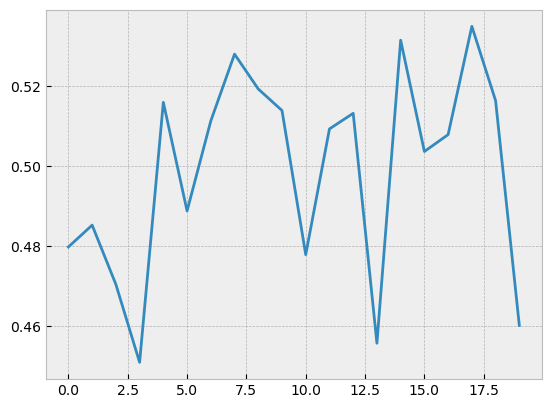

In [207]:
test_scores_ts.plot()

In [208]:
test_scores_ts.mean()

0.49872710790825103

In [209]:
test_scores_ts.median()

0.5085913679300317

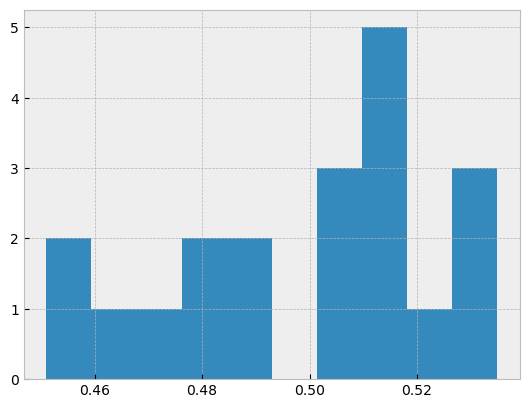

In [210]:
test_scores_ts.hist()

### Classificaation and ROC curve

In [5]:

for m in models:
    for f in fs:
        for t in tickers:
            df = pd.read_csv(os.path.join(os.getcwd(), "results", "forecast", f, m, "indices", "{}.csv".format(t)))



'/Users/danieloliveira/Documents/Daniel/codes/causal_feature/src'

In [20]:
f = "all"
m = "logit"
t = "SPX Index"
df = pd.read_csv(os.path.join(os.getcwd(), "results", "forecast", f, "indices", m, "{}.csv".format(t)))
df.set_index("date", inplace=True)


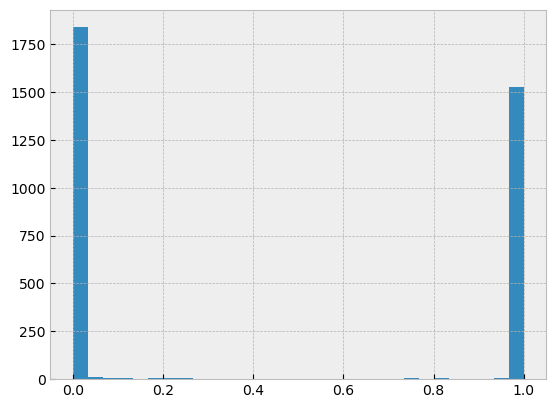

In [21]:
df["prediction"].hist(bins=30)

In [27]:
df.tail()

,return_direction,prediction
date,,
2021-08-25,1,1.000000e+00
2021-08-26,0,1.000000e+00
2021-08-27,1,1.007113e-51
2021-08-30,1,3.326961e-12
2021-08-31,0,5.622762e-135


In [46]:
df.groupby(by=["return_direction"]).count()

,prediction
return_direction,
0,1532
1,1908


### ROC curves and AUC

The roc_curve function from sklearn returns the false positive rates for each threshold, true positive rates for each threshold and thresholds.

In [48]:
buynhold_auc = roc_auc_score(y_true=df["return_direction"], y_score=[1 for _ in range(df.shape[0])])
noskill_auc = roc_auc_score(y_true=df["return_direction"], y_score=[0 for _ in range(df.shape[0])])
model_auc = roc_auc_score(y_true=df["return_direction"], y_score=df["prediction"])

print('Buy n Hold ROC AUC: %.3f' % buynhold_auc)
print('No skill ROC AUC: %.3f' % noskill_auc)
print('Model ROC AUC: %.3f' % model_auc)

Buy n Hold ROC AUC: 0.500
No skill ROC AUC: 0.500
Model ROC AUC: 0.492


Text(0.5, 1.0, 'Logistic vs No skill')

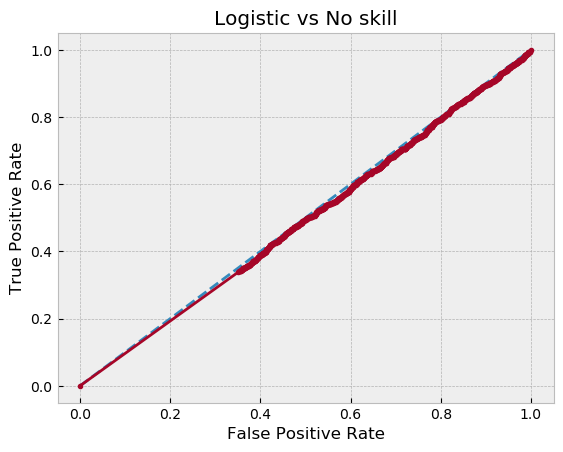

In [54]:
ns_fpr, ns_tpr, _ = roc_curve(df["return_direction"], [0 for _ in range(df.shape[0])])
lr_fpr, lr_tpr, _ = roc_curve(df["return_direction"], df["prediction"])

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Logistic vs No skill")

Text(0.5, 1.0, 'Logistic vs Buy n Hold')

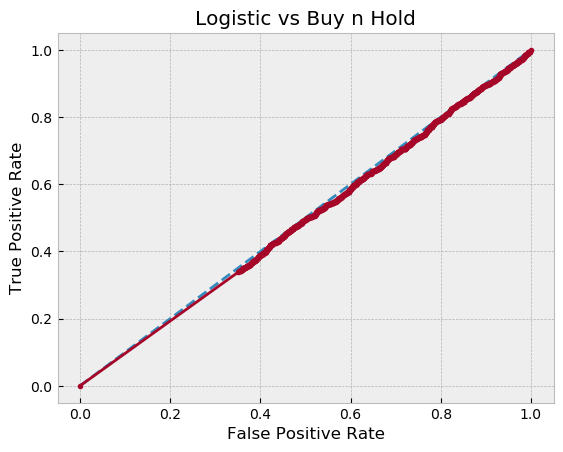

In [53]:
ns_fpr, ns_tpr, _ = roc_curve(df["return_direction"], [1 for _ in range(df.shape[0])])
lr_fpr, lr_tpr, _ = roc_curve(df["return_direction"], df["prediction"])

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Buy n hold')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Logistic vs Buy n Hold")

### How to process google trends data

In [15]:
import pandas as pd
import numpy as np

w = "Bankruptcy"
OUT_FOLDER = "data"
INPUT_FOLDER = os.path.join(os.getcwd(), "data", "all_daily_trends")
N_SAMPLES = 5
START_DATE = "2010-01-01"
sample = 0

In [18]:
gtrends_df = pd.read_csv(os.path.join(INPUT_FOLDER, "daily_trends" + str(sample), w + ".csv"))
gtrends_df["date"] = pd.to_datetime(gtrends_df["date"])
gtrends_df.set_index(["date"], inplace=True)

# resample frequency
gtrends_df = gtrends_df.resample("W-MON").last()

# compute log of values to adjust variance and forward fill values
gtrends_df["{} log".format(w)] = np.log(gtrends_df[w]).replace(np.inf, np.nan).replace(-np.inf, np.nan).ffill()

# compute yoy difference
gtrends_df["{} log yoy".format(w)] = gtrends_df["{} log".format(w)].diff(periods=52)

gtrends_df.tail()

,Bankruptcy,Bankruptcy log,Bankruptcy log yoy
date,,,
2022-08-22,89.0,4.488636,0.428193
2022-08-29,84.0,4.430817,0.460525
2022-09-05,79.0,4.369448,0.457425
2022-09-12,79.0,4.369448,0.362115
2022-09-19,79.0,4.369448,0.326397


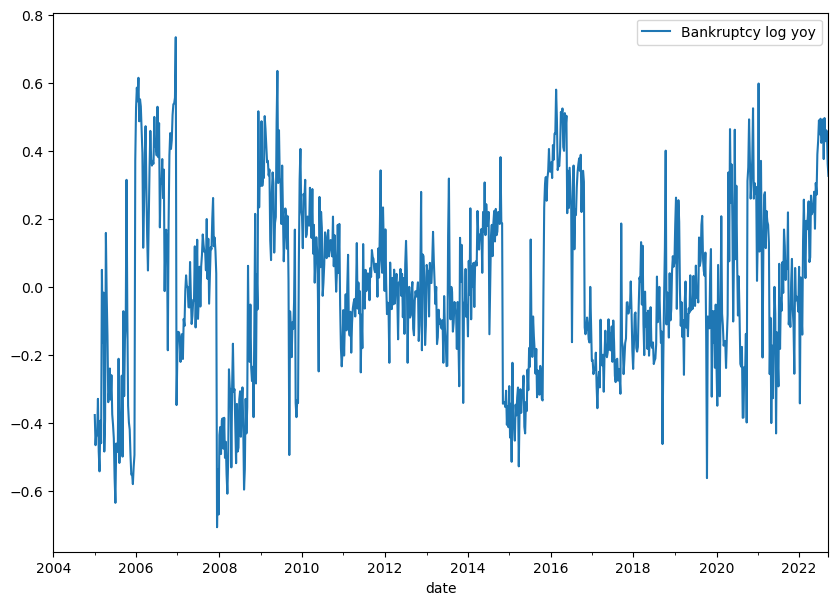

In [19]:
gtrends_df[["Bankruptcy log yoy"]].plot(figsize=(10, 7))

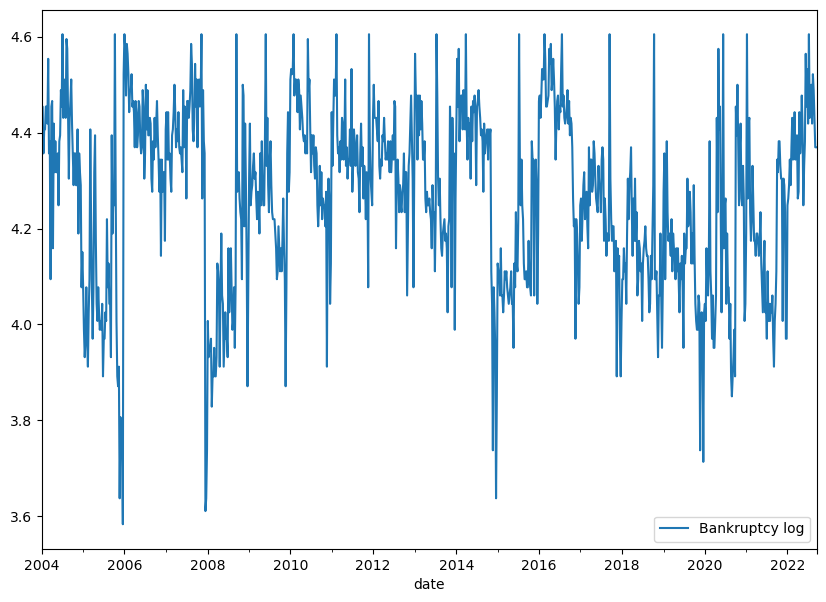

In [17]:
gtrends_df[["Bankruptcy log"]].plot(figsize=(10, 7))

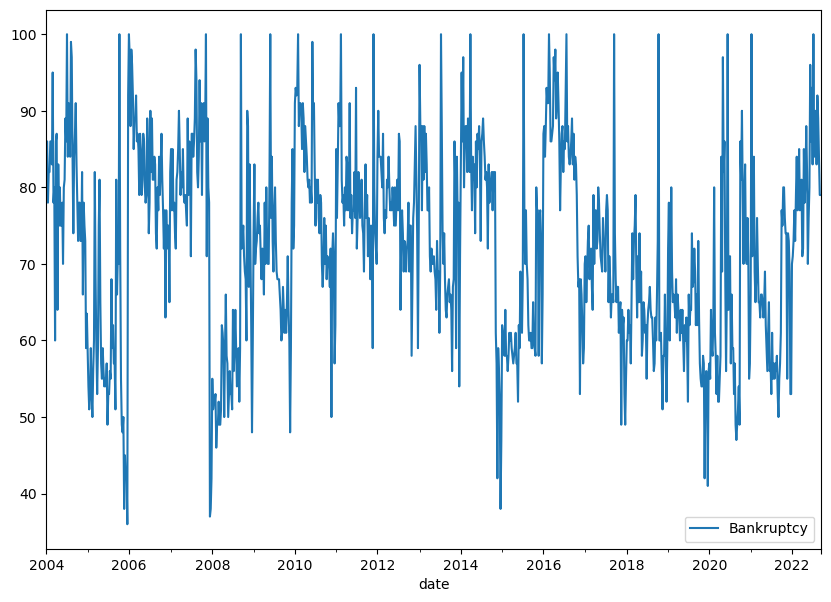

In [12]:
gtrends_df.plot(figsize=(10, 7))

### Check gtrends DB

In [2]:
import pandas as pd

INPUT_FOLDER = os.path.join(os.getcwd(), "data")

In [5]:
gtrends_df = pd.read_csv(os.path.join(INPUT_FOLDER, "gtrends.csv"))
gtrends_df["date"] = pd.to_datetime(gtrends_df["date"])
gtrends_df.set_index(["date"], inplace=True)

gtrends_df.tail()

,Economic crisis,Crisis,Recession,Financial crisis,Krach,Unemployment,Unemployment benefits,Student loan,Credit & Lending,Loan,...,Business Operations,Commercial Vehicles,Agrochemicals,Aviation,Business & Industrial,Chemicals Industry,Food Production,Freight & Trucking,Transportation & Logistics,Manufacturing
date,,,,,,,,,,,,,,,,,,,,,
2022-08-22,0.169376,0.000000,-0.864997,-0.137201,0.537143,0.182322,0.433636,0.597837,-0.792238,0.462035,...,0.057987,0.068208,0.033523,0.298045,-1.354546,-0.664976,-0.110001,-0.052644,1.420619,-0.066249
2022-08-29,0.292853,0.426519,-0.929536,-0.745791,0.187212,0.178248,0.340326,-0.619039,-0.792238,-0.257829,...,0.009143,0.195745,0.033523,0.097638,-0.949081,0.336472,-0.342286,-0.052644,0.169361,-0.089231
2022-09-05,0.149690,0.383959,-1.178655,0.000000,-1.353142,0.070618,0.157629,-1.098612,-0.405465,-0.422857,...,-0.096049,0.025318,0.927341,0.131928,-0.949081,-0.497838,-0.226773,-0.052644,0.082263,-0.144039
2022-09-12,0.405465,0.315081,-1.077559,-0.223144,0.862224,0.318454,0.599621,-1.203973,-0.405465,-0.532217,...,-0.181627,0.152016,0.927341,-0.097374,-0.378066,0.411980,-0.045810,0.097638,1.081705,0.010811
2022-09-19,0.117713,0.046520,-0.980829,-0.203599,-1.049822,0.526093,0.860201,-1.365241,-0.405465,-0.527355,...,-0.158295,-0.141079,-0.057158,0.044452,-0.810930,0.128617,-0.162519,0.941609,1.241570,-0.022990


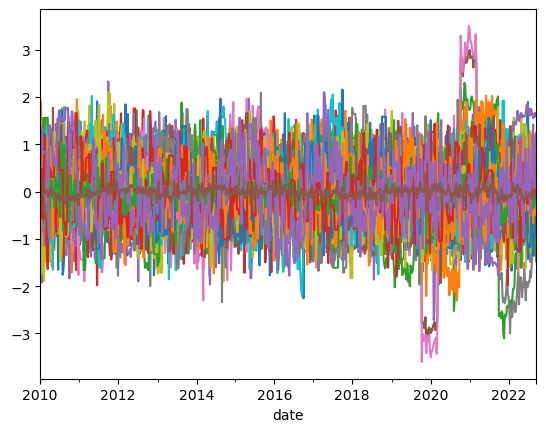

In [14]:
gtrends_df.plot(legend=False)

In [13]:
gtrends_df.describe().T.sort_values(["std"], ascending=False).head(30)

,count,mean,std,min,25%,50%,75%,max
Unemployment benefits,664.0,-0.009070,0.935609,-3.604138,-0.323299,-0.013616,0.337436,3.506558
Recession,664.0,-0.114202,0.853523,-3.106080,-0.380772,-0.019247,0.234401,2.302585
Politics,664.0,0.023162,0.840200,-1.771957,-0.587787,-0.136647,0.660618,1.841770
Unemployment,664.0,-0.020535,0.769327,-3.191847,-0.171324,-0.014926,0.123328,2.995732
Transportation & Logistics,664.0,0.022707,0.754238,-1.779783,-0.532805,0.000000,0.537810,2.100061
Construction & Maintenance,664.0,-0.001245,0.745373,-2.207275,-0.488240,-0.038481,0.503288,2.054124
Tobacco Products,664.0,0.015495,0.739655,-2.302585,-0.293062,0.000000,0.346386,2.031432
Krach,664.0,-0.009252,0.738509,-2.719100,-0.443269,0.025075,0.462624,2.148434
Energy & Utilities,664.0,-0.000670,0.736731,-1.660731,-0.544727,-0.067441,0.528708,1.802122
Swimming Pools & Spas,664.0,-0.002207,0.735367,-1.714798,-0.481838,-0.078602,0.532805,1.813738


### Merge results

In [1]:
import pandas as pd
import os
from sklearn.metrics import make_scorer, roc_auc_score


In [2]:
models = ['logit']
fs_methods = ['all', 'granger', 'huang']
evaluation_start_date='2005-01-03'
evaluation_end_date='2012-07-03'
tickers = ['SPX Index']
metric = 'auc'
benchmark_name = 'return_direction'
tag = "is"

In [3]:
fs_models = fs_methods
prediction_models = models
ticker_names = tickers
metric_name = metric

In [6]:
df = pd.read_csv('results/forecast/' + fs + '/indices/' + model + '/' + ticker + '.csv')
df

,date,return_direction,prediction
0,2015-05-11,0,9.929595e-01
1,2015-05-18,1,9.999840e-01
2,2015-06-01,1,9.999472e-01
3,2015-06-08,0,1.000000e+00
4,2015-06-15,0,9.999993e-01
...,...,...,...
335,2022-06-13,0,1.484566e-11
336,2022-06-27,0,7.156072e-46
337,2022-07-11,0,5.081212e-26
338,2022-07-18,0,2.085104e-13


In [4]:
predictions = []
metrics = []
for fs in fs_models:
    
    fs_name = fs.upper()
    
    for model in prediction_models:
        
        if model == 'random_forest':
            model_name = 'RF'
        elif model == 'lgb':
            model_name = 'GB'
        else:
            model_name = model.upper()
        
        for ticker in ticker_names:
            df = pd.read_csv('results/forecast/' + fs + '/indices/' + model + '/' + ticker + '.csv')
            df.set_index('date', inplace=True)
            df = df.loc[evaluation_start_date:evaluation_end_date]
            df = df.reset_index()

            metric_eval_df = df.copy()
            metric = roc_auc_score(metric_eval_df[benchmark_name].values, metric_eval_df['prediction'].values)
            metric_df = pd.DataFrame([{'ticker': ticker,
                                        'model': model_name,
                                        'fs': fs_name,
                                        tag + metric_name: metric}])
            metrics.append(metric_df)

            melt_df = df.melt('date')
            melt_df['model'] = model_name
            melt_df['fs'] = fs_name
            melt_df['ticker'] = ticker
            predictions.append(melt_df)

predictions_df = pd.concat(predictions, axis=0)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [6]:
benchmark_df = predictions_df.loc[(predictions_df['variable']==benchmark_name)&
                                (predictions_df['fs']==fs_name)&
                                (predictions_df['model']==model_name)]

In [8]:
benchmark_df['model'] = benchmark_df['ticker']
benchmark_df['fs'] = 'raw'
predictions_df = predictions_df.loc[(predictions_df['variable']!=benchmark_name)]
metric_df = pd.concat(metrics, axis=0)

/Users/danieloliveira/opt/anaconda3/envs/dcuoliveira/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/danieloliveira/opt/anaconda3/envs/dcuoliveira/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Group indexes returns

In [2]:
import pandas as pd
import os

In [6]:
market

,date,SPX_Index
0,field,DAY_TO_DAY_TOT_RETURN_GROSS_DVDS
1,date,NaN
2,2000-01-03,-0.9541
3,2000-01-04,-3.8312
4,2000-01-05,0.201
...,...,...
5700,2022-08-25,1.4115
5701,2022-08-26,-3.3662
5702,2022-08-29,-0.6618
5703,2022-08-30,-1.0948


In [14]:
target_name = "SPX_Index"

market = pd.read_csv(os.path.join(os.getcwd(), "data", "indices", "SPX Index.csv"))
market = market.drop([0, 1], 0)  # drop first 2 lines
market.columns = ["date", target_name]
market.loc[:, "date"] = pd.to_datetime(market.date)
market.loc[:, target_name] = market[target_name].astype("float") / 100

market = market.groupby([pd.Grouper(key="date", freq="W-MON")])[[target_name]].sum().reset_index()

market.tail(10)

/Users/danieloliveira/opt/anaconda3/envs/dcuoliveira/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,date,SPX_Index
1174,2022-07-04,-0.018770
1175,2022-07-11,0.008175
1176,2022-07-18,-0.005695
1177,2022-07-25,0.035526
1178,2022-08-01,0.038392
1179,2022-08-08,0.005590
1180,2022-08-15,0.038165
1181,2022-08-22,-0.036873
1182,2022-08-29,-0.025454
1183,2022-09-05,-0.018563


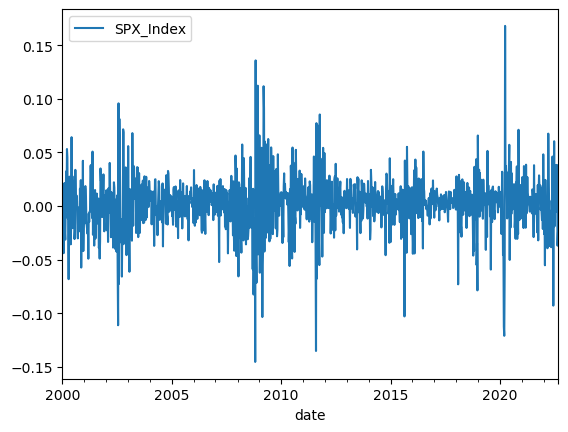

In [11]:
market.groupby([pd.Grouper(key="date", freq="W-MON")])[[target_name]].sum().plot()

In [35]:
import pandas as pd
from pytrends.request import TrendReq, related_topics

ImportError: cannot import name 'related_topics' from 'pytrends.request' (/Users/danieloliveira/opt/anaconda3/envs/dcuoliveira/lib/python3.7/site-packages/pytrends/request.py)

In [24]:
topics = ["Private employment agency" , "House moving", "Unemployment benefits",
          "Recruitment", "Lawyer", "Jobs", "Unemployment", "Office space", "Job search", "Temporary jobs", 
          "Student loan", "Affordable housing", 
          "Krach", "Bank", "Bankruptcy", "Loan", "Interest", "Investment", "Economic crisis", "Financial crisis", "Crisis", 
          "Exportation", "Commercial Building", "Luggage", "Judicial Liquidation", "Foreclosure",
          "Construction", "Retail",
          "Inflation", "CPI", "Rent", "Food prices", "Money", "Used cars", "New cars", "Haircut",
          "Transportation", "Housing", "Budget", "Voucher", "Sale", "Medicine", "Recreation",
          "Education", "Salon Services", 'Public debt', "Housing bubble", "House price index", "Mortgage"]

In [72]:
pytrends.suggestions("services")

[{'mid': '/m/0mgkg', 'title': 'Amazon.com', 'type': 'E-commerce company'},
 {'mid': '/g/11g6qmdb04', 'title': 'Salon Services', 'type': 'Topic'},
 {'mid': '/g/11f0ys_zy8', 'title': 'Alex Hormozi', 'type': 'YouTuber'},
 {'mid': '/m/0crdzxp', 'title': 'Flipkart', 'type': 'Online store company'},
 {'mid': '/g/11vk8rkq5',
  'title': 'Public Services Portal of the Russian Federation',
  'type': 'Portal'}]

In [28]:
all = topics # + crisis_recession + employment + credit + consumption + jobs + bankruptcy + housing + news_politics + construction + personal_finance + business_services + insdustrial_activity

pytrends = TrendReq(hl='en-US', tz=360)

suggs_list = []
for topic in topics:
    suggs = pytrends.suggestions(topic)
    tmp_suggs_df = pd.DataFrame(suggs)
    tmp_suggs_df = tmp_suggs_df.loc[tmp_suggs_df["type"] == "Topic"]

    suggs_list.append(tmp_suggs_df)

suggs_df = pd.concat(suggs_list, axis=0)
suggs_df = suggs_df.reset_index(drop=True)

In [29]:
suggs_df

,mid,title,type
0,/m/01kcnl,Birthday,Topic
1,/g/11g2_mt5qc,Birthday,Topic
2,/m/0h8ndjh,Birthday Candle,Topic
3,/g/1q6n2xr9k,ED-FRO-BON Manpower Services (Private Employme...,Topic
4,/m/0218w7,Unemployment benefits,Topic
...,...,...,...
61,/m/07k55_3,Hand luggage,Topic
62,/g/11h1hvz6l0,Luggage Set,Topic
63,/m/087xfl,Bag tag,Topic
64,/g/11g6qj5ssn,it luggage,Topic


In [37]:
suggs_df["title"].unique()

array(['Birthday', 'Birthday Candle',
       'ED-FRO-BON Manpower Services (Private Employment Agency)',
       'Unemployment benefits', 'Unemployment benefits in New Jersey',
       'Unemployment benefits in New York',
       'Unemployment benefits in Michigan',
       'Unemployment benefits in Connecticut', 'Military recruitment',
       'Investment', 'Mutual fund', 'Investment fund', 'Job',
       'Job hunting', 'economic crisis',
       '2019–present Sri Lankan economic crisis',
       '2001 Turkish economic crisis', 'Unemployment', 'Financial crisis',
       '2007–2008 financial crisis', '1997 Asian financial crisis',
       'National debt of the United States',
       'Ottoman Public Debt Administration', 'Canadian public debt',
       'ZipRecruiter',
       'Fast Job Search (Sarkari Naukri, Board Result, Admit Card, Result)',
       '2000s United States housing bubble', 'House price index',
       'Case–Shiller index', 'Mortgage loan', 'Mortgage law', 'Crisis',
       'Loan', 'L